In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Reshape
from tensorflow import keras

## Przygotowanie danych

In [6]:
df = read_csv('data/data_single_loc.csv')
df

,t2m,d2m,msl,tp,ssrd,Date Time,windspeed_10,windspeed_100
0,262.714033,259.900872,103298.015394,0.000000,0.0,1950-01-01 00:00:00,2.489513,3.817744
1,260.695745,258.184905,103401.866726,0.000000,0.0,1950-01-01 01:00:00,1.837656,3.726080
2,260.195929,257.699157,103434.928307,0.000000,0.0,1950-01-01 02:00:00,2.599009,3.537574
3,259.350219,256.948053,103418.318422,0.000000,0.0,1950-01-01 03:00:00,2.534284,3.147813
4,258.763065,256.665744,103419.030274,0.000000,0.0,1950-01-01 04:00:00,2.623488,3.713367
...,...,...,...,...,...,...,...,...
622387,274.643734,274.172750,100974.912154,0.000006,0.0,2020-12-31 19:00:00,0.809895,1.810642
622388,274.719036,274.144356,100973.148236,0.000005,0.0,2020-12-31 20:00:00,0.868971,1.490224
622389,274.310849,273.971416,100980.668096,0.000003,0.0,2020-12-31 21:00:00,0.774225,1.328229
622390,273.450250,273.092257,100972.962561,0.000002,0.0,2020-12-31 22:00:00,0.649268,0.561700


In [42]:
def datetimeToSignal(df):
    date_time = pd.to_datetime(df.pop('Date Time'), infer_datetime_format=True)

    def datetime_to_seconds(dates):
        return (float)((dates - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s'))

    timestamp_s = date_time.map(datetime_to_seconds)

    day = 24*60*60
    year = (365.2425)*day

    df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
    df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
    
    return df

def to_supervised(data, n_input, n_out=1):
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end < len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[out_end-1, 5]) # 5 indicates 'windspeed10' parameter
        # move along one time step
        in_start += 1
    return array(X), array(y).reshape((len(y),1))

def data_prep(df, noYears, endYear=2001):
    # choosing range
    train = df[df['Date Time']>=(str(endYear+1-noYears)+'-01-01')]
    train = train[train['Date Time']<(str(endYear+1)+'-01-01')]

    # date to signal
    train = datetimeToSignal(train)

    # normalization
    values = train.values
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(values)
    scaler_y = MinMaxScaler(feature_range=(0, 1))
    scaler_y.fit(values[:,5].reshape(len(values),1))
    values = scaler.transform(values)

    # to supervised
    X_train, y_train = to_supervised(values, n_input=24, n_out=6)

    return X_train, y_train, scaler, scaler_y

def compile_and_fit(model, X_train, y_train):
    early_stopping = keras.callbacks.EarlyStopping(monitor='loss',
                                                   patience=2,
                                                   mode='min')

    model.compile(loss='mean_squared_error',
                  optimizer='adam')

    model.fit(X_train, y_train, epochs=20, batch_size=32, callbacks=[early_stopping])

def evaluate(model, X_test, y_test, scaler_y, display = True):
    # make predictions
    testPredictions = model.predict(X_test)

    # invert scalling
    testPredictions = scaler_y.inverse_transform(testPredictions)
    testYTrue = scaler_y.inverse_transform(y_test)

    # calculate RMSE
    testScore = sqrt(mean_squared_error(testYTrue, testPredictions))
    
    if display:
        print('Test Score: %.4f RMSE' % (testScore))

        plt.figure(figsize=[10,5])
        plt.xlabel('TimePoint in hours')
        plt.ylabel('$windspeed_{10}[m/s]$')
        plt.grid()
        plt.plot(range(250), testYTrue[:250],'k.')
        plt.plot(range(250),testPredictions[:250],'r')
        plt.legend(['Actual','Predicted'])

    return testScore

def rmses_calc(model, scaler, scaler_y):
    years = range(2002,2020)
    years = [str(x) for x in years]

    Xs = []
    ys = []
    look_back = 24
    forward = 6

    for year in years:
        test = df[df['Date Time']>=(year+'-01-01')]
        test = test[test['Date Time']<(str(int(year)+1)+'-01-01')]
        test = datetimeToSignal(test)
        test = test.values
        test = scaler.transform(test)
        X, y = to_supervised(test, look_back, forward)
        Xs.append(X)
        ys.append(y)
    
    rmses = []
    for i in range(len(years)):
        rmse = evaluate(model, Xs[i], ys[i], scaler_y, display=False)
        rmses.append(rmse)
    
    return rmses

## Dense model

In [43]:
train_lengths = [1, 2, 5, 10]

dense = Sequential([
    Dense(units=24, activation='relu', input_shape=(24,11)),
    Dense(units=24, activation='relu'),
    Dense(units=24, activation='relu'),
    Dense(1),
    Reshape([1,24]),
    Dense(1),
    Reshape([1])
])

scores = {}

for length in train_lengths:
    X_train, y_train, scaler, scaler_y = data_prep(df, length)
    compile_and_fit(dense, X_train, y_train)
    scores[str(length)] = rmses_calc(dense, scaler, scaler_y)

Epoch 1/20
273/273 [==============================] - 3s 10ms/step - loss: 0.0221
Epoch 2/20
273/273 [==============================] - 2s 8ms/step - loss: 0.0133
Epoch 3/20
273/273 [==============================] - 2s 9ms/step - loss: 0.0121
Epoch 4/20
273/273 [==============================] - 2s 9ms/step - loss: 0.0112
Epoch 5/20
273/273 [==============================] - 2s 8ms/step - loss: 0.0105
Epoch 6/20
273/273 [==============================] - 2s 8ms/step - loss: 0.0101
Epoch 7/20
273/273 [==============================] - 2s 8ms/step - loss: 0.0096
Epoch 8/20
273/273 [==============================] - 2s 9ms/step - loss: 0.0096
Epoch 9/20
273/273 [==============================] - 2s 9ms/step - loss: 0.0093
Epoch 10/20
273/273 [==============================] - 2s 9ms/step - loss: 0.0092
Epoch 11/20
273/273 [==============================] - 2s 9ms/step - loss: 0.0090
Epoch 12/20
273/273 [==============================] - 3s 9ms/step - loss: 0.0090
Epoch 13/20
273/273 [===

Text(0.5, 1.0, 'RMSE comparison for different training set lengths')

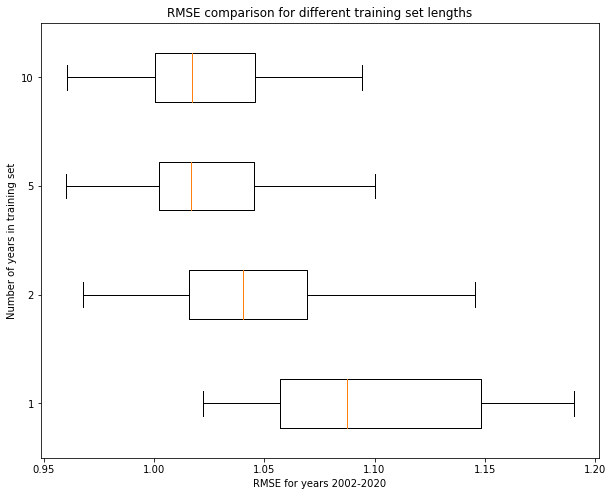

In [44]:
plt.figure(figsize=(10,8))
plt.boxplot(scores.values(), vert=False, labels=scores.keys())
plt.xlabel("RMSE for years 2002-2020")
plt.ylabel("Number of years in training set")
plt.title("RMSE comparison for different training set lengths")

Text(0, 0.5, 'RMSE')

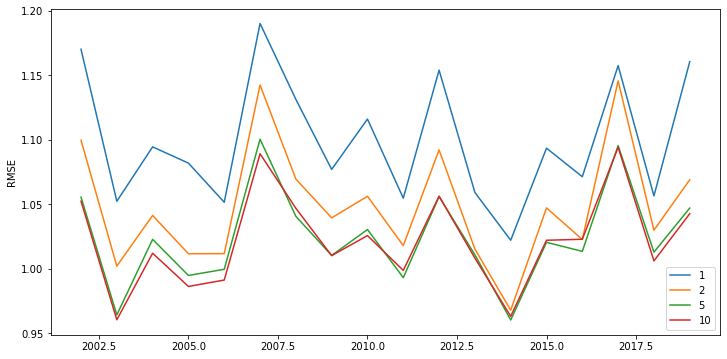

In [45]:
plt.figure(figsize=(12,6))
for key in scores.keys():
    plt.plot(range(2002,2020), scores[key])
plt.legend(scores.keys())
plt.ylabel("RMSE")

## Szukanie najlepszego okresu treningowego

In [57]:
train_lengths = range(1, 11)

dense = Sequential([
    Dense(units=24, activation='relu', input_shape=(24,11)),
    Dense(units=24, activation='relu'),
    Dense(units=24, activation='relu'),
    Dense(1),
    Reshape([1,24]),
    Dense(1),
    Reshape([1])
])

scores = {}

for length in train_lengths:
    X_train, y_train, scaler, scaler_y = data_prep(df, length)
    compile_and_fit(dense, X_train, y_train)
    scores[str(length)] = rmses_calc(dense, scaler, scaler_y)

Epoch 1/20
273/273 [==============================] - 3s 8ms/step - loss: 0.0205
Epoch 2/20
273/273 [==============================] - 2s 9ms/step - loss: 0.0145
Epoch 3/20
273/273 [==============================] - 3s 9ms/step - loss: 0.0133
Epoch 4/20
273/273 [==============================] - 2s 9ms/step - loss: 0.0123
Epoch 5/20
273/273 [==============================] - 3s 10ms/step - loss: 0.0116
Epoch 6/20
273/273 [==============================] - 3s 9ms/step - loss: 0.0109
Epoch 7/20
273/273 [==============================] - 2s 9ms/step - loss: 0.0105
Epoch 8/20
273/273 [==============================] - 2s 9ms/step - loss: 0.0100
Epoch 9/20
273/273 [==============================] - 2s 8ms/step - loss: 0.0096
Epoch 10/20
273/273 [==============================] - 3s 9ms/step - loss: 0.0093
Epoch 11/20
273/273 [==============================] - 2s 8ms/step - loss: 0.0090
Epoch 12/20
273/273 [==============================] - 3s 9ms/step - loss: 0.0091
Epoch 13/20
273/273 [===

In [60]:
avg_scores = []
for key in scores.keys():
    avg_scores.append(np.mean(scores[key]))

Text(0.5, 1.0, 'RMSE comparison for different training set lengths')

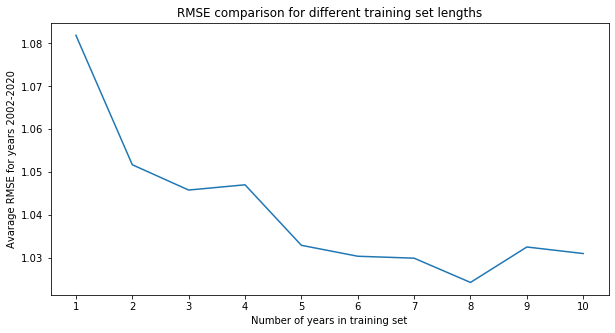

In [66]:
plt.figure(figsize=(10,5))
plt.plot(range(1,11), avg_scores)
plt.xticks(range(1,11))
plt.xlabel("Number of years in training set")
plt.ylabel("Avarage RMSE for years 2002-2020")
plt.title("RMSE comparison for different training set lengths")

## LSTM

In [ ]:
train_lengths = [1, 2, 5, 10]

lstm = Sequential([
    LSTM(24, activation='relu', input_shape=(24,11)),
    Dense(24, activation='relu'),
    Dense(24, activation='relu'),
    Dense(1)
])

scores = {}

for length in train_lengths:
    X_train, y_train, scaler, scaler_y = data_prep(df, length)
    compile_and_fit(lstm, X_train, y_train)
    scores[str(length)] = rmses_calc(lstm, scaler, scaler_y)